### Import packages

In [1]:
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from bayes_opt import BayesianOptimization

from utilities import cal_score, convert_types

### Columns

In [2]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor', 'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area', 'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate', 'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate', 'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250', 'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500', 'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500', 'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500', 'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000', 'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000', 'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000', 'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000', 'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000', 'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN', 'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10', 'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10', 'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN', 'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000', 'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000', 'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500', 'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500', 'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50', 'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000', 'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500', 'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500', 'XIV_index_1000']
cols_feats = cols_num + cols_cat + cols_bin

col_target = 'total_price'
col_target_log1p = 'target'

### Read data

In [3]:
df = pd.read_csv('dataset/train.csv', dtype=object)

In [4]:
df.columns

Index(['building_id', 'building_material', 'city', 'txn_dt', 'total_floor',
       'building_type', 'building_use', 'building_complete_dt', 'parking_way',
       'parking_area',
       ...
       'XIV_500', 'XIV_index_500', 'XIV_1000', 'XIV_index_1000', 'XIV_5000',
       'XIV_index_5000', 'XIV_10000', 'XIV_index_10000', 'XIV_MIN',
       'total_price'],
      dtype='object', length=235)

### Preprocessing

In [5]:
# Convert types
df = convert_types(df, cols_num, col_target=col_target)

# Generate feats (train-test-same feats)
#create_feats(df)

### Target transform

In [6]:
def target_transform(df):  # Add new columns inplace!!
    '''Transform the original target to the target for model to train on'''
    df['log_total_price'] = np.log1p(df['total_price'])
    return df

def target_inverse_transform(df, y_pred):
    '''Inverse transorform the model target to the original target of our problem'''
    y_pred_expm1 = np.expm1(y_pred)
    y_pred_final = np.clip(y_pred_expm1, 0, None)
    return y_pred_final            

In [7]:
df = target_transform(df)

In [8]:
# transformed target fit by the model
col_model_target = 'log_total_price'
#col_model_target = 'total_price'

### Feat engineering

In [9]:
from feature_engineering import CategoricalColumnsEncoder

In [10]:
class FeatureEngineering():
    def __init__(self):
        pass
    
    def fit_transform(self, df, cols_cat, cols_bin):
        df = df.copy()
        # Denote categorical-type
        self.cat_encoder = CategoricalColumnsEncoder(mode='pandas')
        self.cat_encoder.fit_transform(df, cols_cat+cols_bin)
        return df
    
    def transform(self, df):
        df = df.copy()
        self.cat_encoder.transform(df)
        return df

### Prepare kfolds

In [11]:
n_folds = 3
feat_engs = []
df_trains = []
df_vals = []
folds = KFold(n_splits=n_folds, shuffle=True, random_state=246)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    # split train, val
    df_train = df.loc[itrain]
    df_val = df.loc[ival]

    # feat eng
    feat_eng = FeatureEngineering()
    df_train = feat_eng.fit_transform(df_train, cols_cat, cols_bin)
    df_val = feat_eng.transform(df_val)
    
    feat_engs.append(feat_eng)
    df_trains.append(df_train)
    df_vals.append(df_val)

### Early stop

In [12]:
# grid search
params_fix = {'task': 'train',
              'boosting_type': 'gbdt',
              'objective': 'mse',
              'metric': 'mape',
              'learning_rate': 0.015,
              'num_leaves': 255,
              'feature_fraction': 0.5,
              'min_data_in_leaf': 5,
              #'lambda_l1': 0.1,
              #'lambda_l2': 0.1,
             }

In [13]:
def kfold_cv_early_stop(**params_update):
    #params_update = fix_params(params_update)
    params = params_fix.copy()
    params.update(params_update)
    
    lgb_other_params = {'num_boost_round': 25000,
                        'verbose_eval': 2000,
                        'early_stopping_rounds': 1000,
                       }
    
    print('==', params, '==')
    
    scores = []
    scores2 = []
    es_iter = []
    for i_fold, (df_train, df_val) in enumerate(zip(df_trains, df_vals)):
        print('==== Fold', i_fold+1, '====')

        # Construct lgb dataset
        lgb_train = lgb.Dataset(df_train[cols_feats], df_train[col_model_target]).construct()
        lgb_val = lgb.Dataset(df_val[cols_feats], df_val[col_model_target], reference=lgb_train).construct()

        model = lgb.train(params, lgb_train, valid_sets=lgb_val, **lgb_other_params)

        y_pred = model.predict(df_val[cols_feats])

        y_pred_final = target_inverse_transform(df_val, y_pred)

        score = mean_squared_log_error(df_val['total_price'], y_pred_final)
        score2 = cal_score(df_val['total_price'], y_pred_final)
        
        scores.append(score)
        scores2.append(score2)
        es_iter.append(model.best_iteration)
    
    result = [np.mean(scores), scores, np.mean(scores2), scores2, np.mean(es_iter), es_iter]
    print(result)    
    return result

In [14]:
es_result_list = kfold_cv_early_stop()

== {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 5} ==
==== Fold 1 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00878848
[4000]	valid_0's mape: 0.00865646
[6000]	valid_0's mape: 0.00862277
[8000]	valid_0's mape: 0.00861187
[10000]	valid_0's mape: 0.00860747
[12000]	valid_0's mape: 0.00860537
[14000]	valid_0's mape: 0.00860429
[16000]	valid_0's mape: 0.00860363
[18000]	valid_0's mape: 0.00860321
[20000]	valid_0's mape: 0.00860288
[22000]	valid_0's mape: 0.00860269
[24000]	valid_0's mape: 0.00860256
Did not meet early stopping. Best iteration is:
[25000]	valid_0's mape: 0.00860251
==== Fold 2 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00874071
[4000]	valid_0's mape: 0.00862632
[6000]	valid_0's mape: 0.00859739
[8000]	valid_0's mape: 0.00858728
[10000]	valid_0's mape: 0

In [15]:
es_result = {'hit_rate': es_result_list[2], 'MSLE': es_result_list[0], 
             'num_iteration': es_result_list[4]}
es_result

{'MSLE': 0.04205909945408659,
 'hit_rate': 5491.196235744129,
 'num_iteration': 25000.0}

In [16]:
es_result_folds = {'hit_rate': es_result_list[3], 
                  'MSLE': es_result_list[1],
                  'num_iteration': es_result_list[5]}

In [17]:
df_es_result_folds = pd.DataFrame(es_result_folds).sort_values('num_iteration')
df_es_result_folds

,MSLE,hit_rate,num_iteration
0,0.043603,5497.862615,25000
1,0.041345,5504.862668,25000
2,0.041230,5470.863424,25000


### Grid search iteration

In [18]:
def kfold_cv_grid_search_iteration(iter_min, iter_max, iter_step, **params_update):
    #params_update = fix_params(params_update)
    params = params_fix.copy()
    params.update(params_update)
    
    lgb_other_params = {'num_boost_round': iter_max,
                        'verbose_eval': 2000,
                       }
    iter_list = list(range(iter_min, iter_max+1, iter_step))
    
    print('==', params, '==')
    print(iter_list)
    
    results = []
    models = []
    for i_fold, (df_train, df_val) in enumerate(zip(df_trains, df_vals)):
        print('==== Fold', i_fold+1, '====')

        # Construct lgb dataset
        lgb_train = lgb.Dataset(df_train[cols_feats], df_train[col_model_target]).construct()
        #lgb_val = lgb.Dataset(df_val[cols_feats], df_val[col_model_target], reference=lgb_train).construct()

        model = lgb.train(params, lgb_train, **lgb_other_params) # valid_sets=lgb_val, 
        
        for num_iteration in iter_list:
            result = {
                'i_fold': i_fold,
                'num_iteration': num_iteration,
            }
            
            # Validation set
            y_pred = model.predict(df_val[cols_feats], num_iteration=num_iteration)
            y_pred_final = target_inverse_transform(df_val, y_pred)
            result['msle'] = mean_squared_log_error(df_val['total_price'], y_pred_final)
            result['hit_rate'] = cal_score(df_val['total_price'], y_pred_final)
            
            # Train set
            y_pred = model.predict(df_train[cols_feats], num_iteration=num_iteration)
            y_pred_final = target_inverse_transform(df_train, y_pred)
            result['msle_train'] = mean_squared_log_error(df_train['total_price'], y_pred_final)
            result['hit_rate_train'] = cal_score(df_train['total_price'], y_pred_final)
            
            print(result)
            results.append(result)
        models.append(model)
        
    return results, models

In [19]:
%%time
iter_search_results, fold_models = kfold_cv_grid_search_iteration(iter_min=4000, iter_max=25000, iter_step=500)

== {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 5} ==
[4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 14000, 14500, 15000, 15500, 16000, 16500, 17000, 17500, 18000, 18500, 19000, 19500, 20000, 20500, 21000, 21500, 22000, 22500, 23000, 23500, 24000, 24500, 25000]
==== Fold 1 ====
{'i_fold': 0, 'num_iteration': 4000, 'msle': 0.04371012012069039, 'hit_rate': 5478.861776667309, 'msle_train': 0.0003337861534159355, 'hit_rate_train': 9983.987251633564}
{'i_fold': 0, 'num_iteration': 4500, 'msle': 0.04367259202895893, 'hit_rate': 5484.861980290803, 'msle_train': 0.00023692634098632337, 'hit_rate_train': 9988.989590998306}
{'i_fold': 0, 'num_iteration': 5000, 'msle': 0.043651506743377616, 'hit_rate': 5485.862113809584, 'msle_train': 0.0001723074470723245, 'hit_rate_train': 9993.991419871916}


{'i_fold': 1, 'num_iteration': 5000, 'msle': 0.04133373411634824, 'hit_rate': 5512.86218079695, 'msle_train': 0.00027642872639802095, 'hit_rate_train': 9994.99128494778}
{'i_fold': 1, 'num_iteration': 5500, 'msle': 0.041337102271696576, 'hit_rate': 5508.862286421282, 'msle_train': 0.00023045818323121404, 'hit_rate_train': 9997.992769319588}
{'i_fold': 1, 'num_iteration': 6000, 'msle': 0.04134129083371592, 'hit_rate': 5508.862358894213, 'msle_train': 0.0001994981938993392, 'hit_rate_train': 9998.993939083133}
{'i_fold': 1, 'num_iteration': 6500, 'msle': 0.04134386104091699, 'hit_rate': 5508.86241839365, 'msle_train': 0.00017725661750536687, 'hit_rate_train': 9998.994905799243}
{'i_fold': 1, 'num_iteration': 7000, 'msle': 0.04134508894627912, 'hit_rate': 5509.862459463061, 'msle_train': 0.00016146205181699714, 'hit_rate_train': 10000.995691429443}
{'i_fold': 1, 'num_iteration': 7500, 'msle': 0.041342182764540554, 'hit_rate': 5506.862495128749, 'msle_train': 0.00015009620379013264, 'hit_r

{'i_fold': 2, 'num_iteration': 7500, 'msle': 0.04123313792530468, 'hit_rate': 5463.863236039298, 'msle_train': 4.176318022320306e-05, 'hit_rate_train': 9998.996371975445}
{'i_fold': 2, 'num_iteration': 8000, 'msle': 0.041232653735834915, 'hit_rate': 5462.863273104518, 'msle_train': 3.264163065809875e-05, 'hit_rate_train': 9999.996913340568}
{'i_fold': 2, 'num_iteration': 8500, 'msle': 0.041233197935687076, 'hit_rate': 5465.86329736418, 'msle_train': 2.6079851519419577e-05, 'hit_rate_train': 9999.997361816422}
{'i_fold': 2, 'num_iteration': 9000, 'msle': 0.04123210071058142, 'hit_rate': 5465.863312789913, 'msle_train': 2.1133348406199482e-05, 'hit_rate_train': 9999.997733756541}
{'i_fold': 2, 'num_iteration': 9500, 'msle': 0.04123068573859769, 'hit_rate': 5464.863329231238, 'msle_train': 1.7418967432270898e-05, 'hit_rate_train': 9999.998049406413}
{'i_fold': 2, 'num_iteration': 10000, 'msle': 0.041230311861692064, 'hit_rate': 5466.863342402248, 'msle_train': 1.4235566111642678e-05, 'hit

In [20]:
df_results = pd.DataFrame(iter_search_results).sort_values(['num_iteration', 'i_fold'])
df_results

,hit_rate,hit_rate_train,i_fold,msle,msle_train,num_iteration
0,5478.861777,9983.987252,0,0.043710,0.000334,4000
43,5513.861876,9986.987130,1,0.041350,0.000439,4000
86,5450.862556,9981.986927,2,0.041271,0.000357,4000
1,5484.861980,9988.989591,0,0.043673,0.000237,4500
44,5512.862054,9992.989488,1,0.041335,0.000339,4500
87,5446.862757,9986.989280,2,0.041255,0.000253,4500
2,5485.862114,9993.991420,0,0.043652,0.000172,5000
45,5512.862181,9994.991285,1,0.041334,0.000276,5000
88,5454.862897,9992.991196,2,0.041245,0.000181,5000
3,5482.862220,9995.992902,0,0.043635,0.000126,5500


In [21]:
df_results_iter = df_results.groupby('num_iteration')[['msle_train', 'msle', 'hit_rate_train', 'hit_rate', ]].agg('mean').reset_index()
df_results_iter

,num_iteration,msle_train,msle,hit_rate_train,hit_rate
0,4000,0.000377,0.042110,9984.320436,5481.195403
1,4500,0.000277,0.042087,9989.656120,5481.528930
2,5000,0.000210,0.042077,9993.991300,5484.529064
3,5500,0.000163,0.042069,9996.326119,5482.862504
4,6000,0.000130,0.042067,9997.993975,5484.862578
5,6500,0.000107,0.042065,9998.661609,5487.195971
6,7000,0.000091,0.042065,9999.329074,5489.196018
7,7500,0.000079,0.042063,9999.996386,5487.862721
8,8000,0.000070,0.042061,10000.330257,5487.862756
9,8500,0.000063,0.042060,10000.330696,5490.529445


In [22]:
# best iteration
[m.best_iteration for m in fold_models]

[0, 0, 0]

### Plots

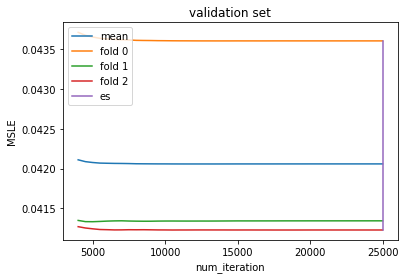

In [23]:
plt.plot(df_results_iter['num_iteration'], df_results_iter['msle'], label='mean')
for i_fold in range(len(df_trains)):
    df_temp = df_results.loc[df_results['i_fold']==i_fold]
    plt.plot(df_temp['num_iteration'], df_temp['msle'], label='fold '+str(i_fold))
plt.plot(df_es_result_folds['num_iteration'], df_es_result_folds['MSLE'], label='es')
plt.xlabel('num_iteration'); plt.ylabel('MSLE')
plt.legend(); plt.title('validation set'); plt.show()

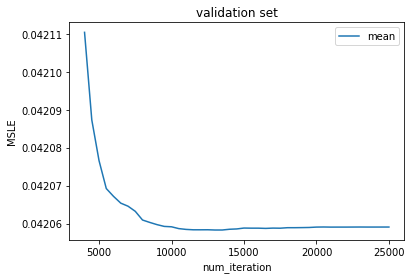

In [27]:
plt.plot(df_results_iter['num_iteration'], df_results_iter['msle'], label='mean')
plt.xlabel('num_iteration'); plt.ylabel('MSLE')
plt.legend(); plt.title('validation set'); plt.show()

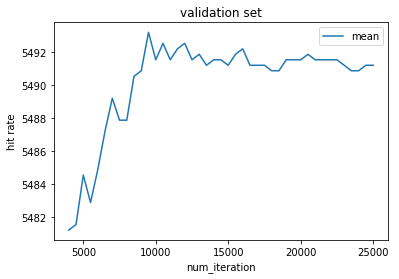

In [28]:
plt.plot(df_results_iter['num_iteration'], df_results_iter['hit_rate'], label='mean')
plt.xlabel('num_iteration'); plt.ylabel('hit rate')
plt.legend(); plt.title('validation set'); plt.show()

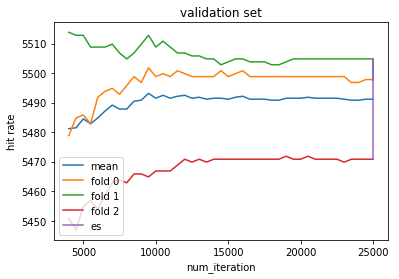

In [24]:
plt.plot(df_results_iter['num_iteration'], df_results_iter['hit_rate'], label='mean')
for i_fold in range(len(df_trains)):
    df_temp = df_results.loc[df_results['i_fold']==i_fold]
    plt.plot(df_temp['num_iteration'], df_temp['hit_rate'], label='fold '+str(i_fold))    
plt.plot(df_es_result_folds['num_iteration'], df_es_result_folds['hit_rate'], label='es')
plt.xlabel('num_iteration'); plt.ylabel('hit rate')
plt.legend(); plt.title('validation set'); plt.show()

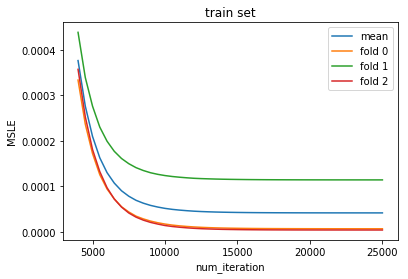

In [25]:
plt.plot(df_results_iter['num_iteration'], df_results_iter['msle_train'], label='mean')
for i_fold in range(len(df_trains)):
    df_temp = df_results.loc[df_results['i_fold']==i_fold]
    plt.plot(df_temp['num_iteration'], df_temp['msle_train'], label='fold '+str(i_fold))
#plt.plot(df_es_result_folds['num_iteration'], df_es_result_folds['MSLE'], label='es')
plt.xlabel('num_iteration'); plt.ylabel('MSLE')
plt.legend(); plt.title('train set'); plt.show()

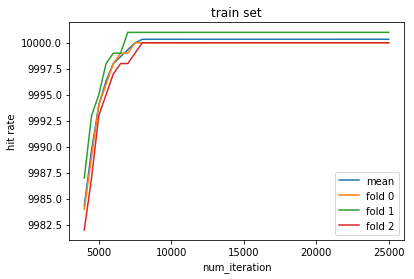

In [26]:
plt.plot(df_results_iter['num_iteration'], df_results_iter['hit_rate_train'], label='mean')
for i_fold in range(len(df_trains)):
    df_temp = df_results.loc[df_results['i_fold']==i_fold]
    plt.plot(df_temp['num_iteration'], df_temp['hit_rate_train'], label='fold '+str(i_fold))    
#plt.plot(df_es_result_folds['num_iteration'], df_es_result_folds['hit_rate'], label='es')
plt.xlabel('num_iteration'); plt.ylabel('hit rate')
plt.legend(); plt.title('train set'); plt.show()

In [34]:
def kfold_cv_iteration_evaluation(models, iter_min, iter_max, iter_step, results=[]):
    if iter_max > 
    iter_list = list(range(iter_min, iter_max+1, iter_step))
    
    print(iter_list)
    for i_fold, (df_train, df_val, model) in enumerate(zip(df_trains, df_vals, models)):
        print('==== Fold', i_fold+1, '====')
        
        for num_iteration in iter_list:
            result = {
                'i_fold': i_fold,
                'num_iteration': num_iteration,
            }
            
            # Validation set
            y_pred = model.predict(df_val[cols_feats], num_iteration=num_iteration)
            y_pred_final = target_inverse_transform(df_val, y_pred)
            result['msle'] = mean_squared_log_error(df_val['total_price'], y_pred_final)
            result['hit_rate'] = cal_score(df_val['total_price'], y_pred_final)
            
            # Train set
            y_pred = model.predict(df_train[cols_feats], num_iteration=num_iteration)
            y_pred_final = target_inverse_transform(df_train, y_pred)
            result['msle_train'] = mean_squared_log_error(df_train['total_price'], y_pred_final)
            result['hit_rate_train'] = cal_score(df_train['total_price'], y_pred_final)

            print(result)
            
            results.append(result)
        
    return results

### Conclusion

- Round 1 best params (random seed = 123):
   ('task', 'train'),  
   ('boosting_type', 'gbdt'),  
   ('objective', 'mse'),  
   ('metric', 'mape'),  
   ('learning_rate', 0.015),  
   ('num_leaves', 255),  
   ('feature_fraction', 0.5),  
   ('min_data_in_leaf', 5)),  

Best scores: 5501.863278855861  
[5527.864888142274, 5498.864225711784, 5478.860722713526]

- Round 2 best params (random seed = 123):  
   ('task', 'train'),  
   ('boosting_type', 'gbdt'),  
   ('objective', 'mse'),  
   ('metric', 'mape'),  
   ('learning_rate', 0.015),  
   ('num_leaves', 255),  
   ('feature_fraction', 0.5),  
   ('min_data_in_leaf', 5),  
   ('lambda_l1', 0.1),  
   ('lambda_l2', 0)  
  
Best scores: *5515.529915334645*  
[5532.864763855017, 5514.864357360793, 5498.860624788125]

- Round 2 best params (random seed = 246):  
   ('task', 'train'),  
   ('boosting_type', 'gbdt'),  
   ('objective', 'mse'),  
   ('metric', 'mape'),  
   ('learning_rate', 0.015),  
   ('num_leaves', 255),  
   ('feature_fraction', 0.5),  
   ('min_data_in_leaf', 5),  
   ('lambda_l1', 0.1),  
   ('lambda_l2', 0.1)  
   
Best scores: *5524.863045737181*  
[5528.862755759428, 5530.862894274216, 5514.863487177898]

### Other info

In [ ]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5)
plt.show()

In [ ]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5, importance_type='gain')
plt.show()